In [ ]:
#!/usr/bin/env python3
# 53907afe-531b-11ea-a595-00505601122b
# b7ea974c-d389-11e8-a4be-00505601122b

This assignment introduces first NLP task. Your goal is to implement a model which is given Czech lowercased text and tries to uppercase appropriate letters. To load the dataset, use uppercase_data.py module which loads (and if required also downloads) the data. While the training and the development sets are in correct case, the test set is lowercased.

This is an open-data task, where you submit only the uppercased test set together with the training script (which will not be executed, it will be only used to understand the approach you took, and to indicate teams). Explicitly, submit exactly one .txt file and at least one .py/ipynb file.

The task is also a competition. Everyone who submits a solution which achieves at least 98.5% accuracy will get 4 basic points; the 5 bonus points will be distributed depending on relative ordering of your solutions. The accuracy is computed per-character and can be evaluated by running uppercase_data.py with --evaluate argument, or using its evaluate_file method.

You may want to start with the uppercase.py template, which uses the uppercase_data.py to load the data, generate an alphabet of given size containing most frequent characters, and generate sliding window view on the data. The template also comments on possibilities of character representation.

Do not use RNNs, CNNs or Transformer in this task (if you have doubts, contact me).

**Notes**
- the average word length (in text) in czech is 5.54 according to https://nlp.fi.muni.cz/cs/FrekvenceSlovLemmat

In [1]:
!cp /kaggle/input/uppercase-data/uppercase_data.py /kaggle/working/uppercase_data.py

In [2]:
!pip install -U tensorflow==2.8 tensorflow-addons==0.16.1 tensorflow-probability==0.16.0 tensorflow-hub==0.12.0 scipy
!pip freeze | grep tensorflow

     |████████████████████████████████| 497.5 MB 21 kB/s              
     |████████████████████████████████| 1.1 MB 37.9 MB/s            
     |████████████████████████████████| 6.3 MB 28.9 MB/s            
     |████████████████████████████████| 2.1 MB 36.9 MB/s            
     |████████████████████████████████| 1.4 MB 42.5 MB/s            
     |████████████████████████████████| 14.5 MB 38.5 MB/s            
     |████████████████████████████████| 5.8 MB 38.5 MB/s            
     |████████████████████████████████| 462 kB 45.8 MB/s            
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.14.1
    Uninstallin

In [2]:
import argparse
import datetime
import os
import re

os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from uppercase_data import UppercaseData

In [3]:
uppercase_data = UppercaseData(4, 40)
print(uppercase_data.test.alphabet)

['<pad>', '<unk>', ' ', 'o', 'e', 'a', 'n', 's', 't', 'i', 'l', 'r', 'v', 'k', 'd', 'm', 'u', 'p', 'c', 'í', 'h', 'z', 'á', 'j', 'b', 'y', '.', 'ě', 'é', ',', '\n', 'ř', 'ý', 'č', 'ž', 'š', '1', 'g', 'f', 'ů']


In [36]:
args = {
    'batch_size': 256,
    'epochs': 20,
    'seed': 42,
    'threads': 1,
    'window': 4,
    'alphabet_size': 40,
    'label_smoothing': 0.1,
    'learning_rate': 0.01, #starting LR
    'momentum': None,
    'class_weight': None,
    'stopping_patience': 3,
    'checkpoint_period': 1,
    'num_models': 5,
    'skip_conn_each_nth': 2,
    'neurons': [128, 128, 128, 128, 128, 128],
}

args['num_nn_blocks'] = len(args['neurons'])
args['decay_steps'] = int(args['epochs'] * uppercase_data.train.size / args['batch_size'])
#low_w, upp_w = len(uppercase_data.train.data['labels']) / (2 * np.bincount(uppercase_data.train.data['labels']))
#args['class_weight'] = {0: low_w, 1: upp_w}

# Create logdir name
args['logdir'] = os.path.join(
    "logs",
    "{}-{}-{}".format(
        os.path.basename(globals().get("__file__", "notebook")),
        datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S"),
        ",".join(
            (
                "{}={}".format(re.sub("(.)[^_]*_?", r"\1", k), v)
                for k, v in sorted(args.items())
            )
        ),
    ),
)

In [37]:
models = []
L = [[] for _ in range(args['num_models'])] # Layers

for i in range(args['num_models']):
    L.append([])

    L[i].append(tf.keras.layers.Input(shape=[2 * args['window'] + 1], dtype=tf.int32)) 
    L[i].append(tf.keras.layers.Embedding(args['alphabet_size'], args['alphabet_size'])(L[i][-1]))
    L[i].append(tf.keras.layers.Flatten()(L[i][-1]))
    L[i].append(tf.keras.layers.GaussianNoise(.1)(L[i][-1])) 
    
    for j in range(args['num_nn_blocks']):
        L[i].append(tf.keras.layers.Dense(args['neurons'][j])(L[i][-1])) # kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)    
        if j != 0:
            x = tf.keras.layers.Add()([L[i][-1], L[i][j * 4]])
        else:
            x = L[i][-1]
        L[i].append(tf.keras.layers.BatchNormalization()(x))
        L[i].append(tf.keras.layers.Activation('swish')(L[i][-1]))
        L[i].append(tf.keras.layers.Dropout(.4)(L[i][-1]))
        
    L[i].append(tf.keras.layers.Dense(1, activation='sigmoid')(L[i][-1]))
    models.append(tf.keras.Model(inputs=L[i][0], outputs=L[i][-1]))

model_input = tf.keras.layers.Input(shape=[2 * args['window'] + 1], dtype=tf.int32)
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(
    inputs=model_input,
    outputs=ensemble_output
)

ensemble_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.CosineDecay(args['learning_rate'], args['decay_steps']),
        #momentum=args['momentum']
        ),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=args['label_smoothing']),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.BinaryCrossentropy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.FalsePositives(),
             tf.keras.metrics.TruePositives(),
             tf.keras.metrics.FalseNegatives(),
             tf.keras.metrics.TrueNegatives()]
)

ensemble_model.summary()

Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
model_54 (Functional)           (None, 1)            133569      input_70[0][0]                   
__________________________________________________________________________________________________
model_55 (Functional)           (None, 1)            133569      input_70[0][0]                   
__________________________________________________________________________________________________
model_56 (Functional)           (None, 1)            133569      input_70[0][0]                   
___________________________________________________________________________________________

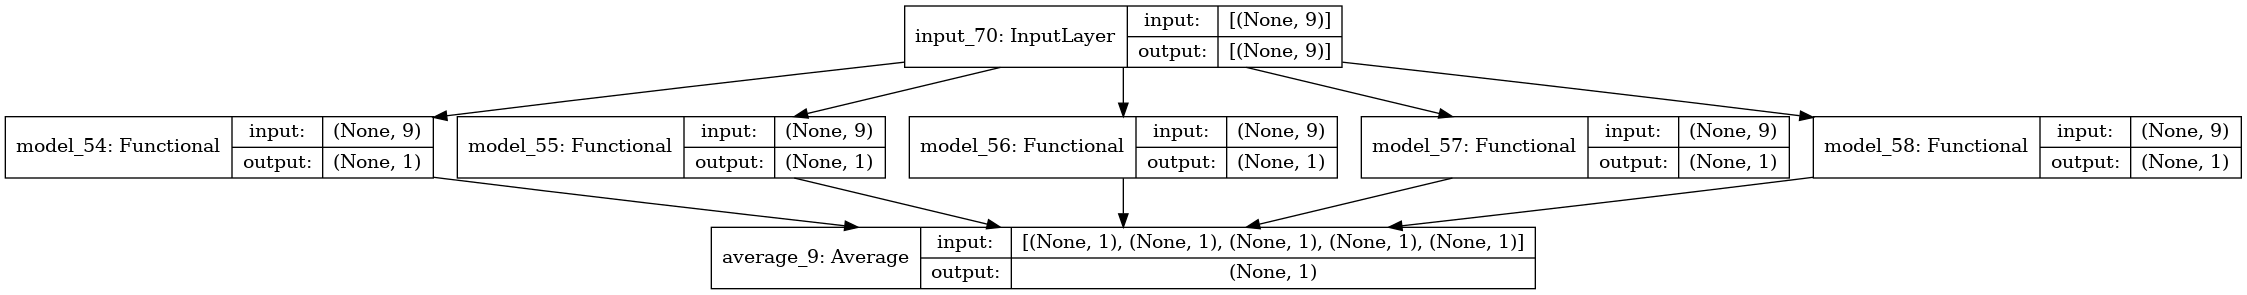

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(ensemble_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
tb_callback = tf.keras.callbacks.TensorBoard(args['logdir'], histogram_freq=1, update_freq=100, profile_batch=0)
tb_callback._close_writers = lambda: None  # A hack allowing to keep the writers open.
checkpoints = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True, period=args['checkpoint_period']) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=args['stopping_patience'])

ensemble_model.fit(
    uppercase_data.train.data['windows'], uppercase_data.train.data['labels'],
    batch_size=args['batch_size'], epochs=args['epochs'],
    validation_data=(uppercase_data.dev.data["windows"], uppercase_data.dev.data["labels"]),
    callbacks=[tb_callback, checkpoints, early_stopping],
    class_weight=args['class_weight']
)

test_logs = ensemble_model.evaluate(
    uppercase_data.test.data["windows"], uppercase_data.test.data["labels"], batch_size=args['batch_size'], return_dict=True,
)
tb_callback.on_epoch_end(args['epochs'], {"val_test_" + metric: value for metric, value in test_logs.items()})

test_logs

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
23875/23875 [==============================] - 775s 32ms/step - loss: 0.2377 - binary_accuracy: 0.9757 - binary_crossentropy: 0.1038 - auc_9: 0.9723 - precision_9: 0.8122 - false_positives_9: 31926.0000 - true_positives_9: 138035.0000 - false_negatives_9: 116339.0000 - true_negatives_9: 5825690.0000 - val_loss: 0.2304 - val_binary_accuracy: 0.9801 - val_binary_crossentropy: 0.0987 - val_auc_9: 0.9825 - val_precision_9: 0.8402 - val_false_positives_9: 1952.0000 - val_true_positives_9: 10264.0000 - val_false_negatives_9: 5260.0000 - val_true_negatives_9: 345512.0000
Epoch 2/20
23875/23875 [==============================] - 771s 32ms/step - loss: 0.2306 - binary_accuracy: 0.9804 - binary_crossentropy: 0.0946 - auc_9: 0.9793 - precision_9: 0.8432 - false_positives_9: 30821.0000 - true_positives_9: 165699.0000 - false_negatives_9: 88675.0000 - true_negatives_9: 5826795.0000 - val_loss: 0.2271 - val_binary_accuracy: 0.9823 - val_binary_crossentropy: 0.0885 - val_auc_9: 0.9881 - va

{'loss': 0.2592291831970215,
 'binary_accuracy': 0.9614900350570679,
 'binary_crossentropy': 0.12336660176515579,
 'auc_9': 0.0,
 'precision_9': 0.0,
 'false_positives_9': 14015.0,
 'true_positives_9': 0.0,
 'false_negatives_9': 0.0,
 'true_negatives_9': 349917.0}

In [40]:
model_dump_path = os.path.join(args['logdir'], 'final_5ensemble_6x128_hidden_blocks_with_skip_connections.tf')
ensemble_model.save(model_dump_path,save_format='tf')
# del ensemble_model

#ensemble_model_todo = tf.keras.models.load_model(model_dump_path)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [41]:
logits = ensemble_model.predict(uppercase_data.test.data['windows'])
capitalized = ""
for i in range(len(logits)):
    capitalized += uppercase_data.test.text[i].capitalize() if logits[i] > 0.5 else uppercase_data.test.text[i]
    os.makedirs(args['logdir'], exist_ok=True)
    
with open(
    os.path.join(args['logdir'], "uppercase_test.txt"), "w", encoding="utf-8"
) as predictions_file:
    predictions_file.write(capitalized)